In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
# print folder directory
print(os.getcwd())

/Users/omer/Library/CloudStorage/GoogleDrive-omerulfaruk97@gmail.com/My Drive/MyReposDrive/obsidian_Notes/Landy Omer Re 1/av-dur-estimation/mainExpAvDurEstimate


Merge sessions

In [31]:
session1="lc_1_mainExpAvDurEstimate_2025-04-18_15h29.06.213.csv"
session2="lc_2_mainExpAvDurEstimate_2025-04-17_17h20.12.169.csv"
session3="lc_3_mainExpAvDurEstimate_2025-04-18_18h42.03.375.csv"

folder="dataAvMain/"
# merge sessions
def merge_sessions(session1, session2, session3):
    # Read the CSV files into DataFrames
    df1 = pd.read_csv(folder+session1)
    df2 = pd.read_csv(folder+session2)
    df3 = pd.read_csv(folder+session3)

    # Merge the DataFrames
    merged_df = pd.concat([df1, df2, df3], ignore_index=True)

    return merged_df
# Merge the sessions
merged_df = merge_sessions(session1, session2, session3)
# Print the merged DataFrame
print(merged_df.head())
# Save the merged DataFrame to a new CSV file
data=merged_df
data[:4]
data['avgAVDeltaS'] = (data['deltaDurS'] + (data['recordedDurVisualTest'] - data['recordedDurVisualStandard'])) / 2
# Calculate deltaDurPercentVisual just as the difference between the test and standard visual durations over the standard visual duration
data['deltaDurPercentVisual'] = ((data['recordedDurVisualTest'] - data['recordedDurVisualStandard']) / data['recordedDurVisualStandard'] 
)
data['avgAVDeltaPercent'] = data[['delta_dur_percents', 'deltaDurPercentVisual']].mean(axis=1)
data

# Define columns for chosing test or standard
data['chose_test'] = (data['responses'] == data['order']).astype(int)
data['chose_standard'] = (data['responses'] != data['order']).astype(int)
try:
    data["riseDur"]>1
except:
    data["riseDur"]=1

data['standard_dur']=data['standardDur']
data[:3]
data = data[data['audNoise'] != 0]
data['visualPSEBias'] = data['recordedDurVisualStandard'] -data["standardDur"]-data['conflictDur']
data=data[data['recordedDurVisualStandard'] <=998]
data=data[data['recordedDurVisualStandard'] >=0]
data=data[data['recordedDurVisualTest'] >0]
data

   Unnamed: 0  standardDur  audNoise  order   preDur  postDur   isiDur  \
0           0      0.49684       1.2      1  0.30315  0.21895  0.88420   
1           1      0.49684       1.2      2  0.30315  0.42105  0.69894   
2           2      0.49684       0.1      1  0.32000  0.40421  0.65684   
3           3      0.49684       0.1      2  0.40421  0.42947  0.75789   
4           4      0.49684       0.1      1  0.23579  0.22737  0.57263   

   trial_num  totalDur  delta_dur_percents  ...  stair_is_reversal  \
0          0   2.05472               -0.70  ...              False   
1          1   2.77050                0.70  ...              False   
2          2   2.72841                0.70  ...              False   
3          3   2.16420               -0.85  ...              False   
4          4   2.43367                0.80  ...              False   

   response_keys  conflictDur recordedOnsetVisualTest  \
0           left      0.16842                  0.2632   
1          right    

,Unnamed: 0,standardDur,audNoise,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,recordedDurVisualStandard,modalityCue,avgAVDeltaS,deltaDurPercentVisual,avgAVDeltaPercent,chose_test,chose_standard,riseDur,standard_dur,visualPSEBias
0,0,0.49684,1.2,1,0.30315,0.21895,0.88420,0,2.05472,-0.700,...,0.7253,A,-0.431440,-0.702054,-0.701027,1,0,1,0.49684,0.06004
1,1,0.49684,1.2,2,0.30315,0.42105,0.69894,1,2.77050,0.700,...,0.4748,A,0.343640,0.702612,0.701306,1,0,1,0.49684,0.06217
2,2,0.49684,0.1,1,0.32000,0.40421,0.65684,2,2.72841,0.700,...,0.3912,A,0.268690,0.469581,0.584790,1,0,1,0.49684,-0.27406
4,4,0.49684,0.1,1,0.23579,0.22737,0.57263,4,2.43367,0.800,...,0.3916,A,0.318705,0.595506,0.697753,1,0,1,0.49684,-0.27366
6,6,0.49684,1.2,2,0.26105,0.22737,0.74947,6,2.50946,0.550,...,0.7248,A,0.143095,0.011451,0.280726,0,1,1,0.49684,0.05954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2149,609,0.50002,1.2,1,0.44169,0.35002,0.74170,609,2.60846,0.152,...,0.3163,A,0.200100,1.028138,0.590069,1,0,1,0.50002,0.06629
2150,610,0.50002,0.1,1,0.39168,0.37502,0.42502,610,2.35010,0.310,...,0.3166,A,0.116820,0.237840,0.273920,1,0,1,0.50002,-0.26676
2152,612,0.50002,1.2,2,0.44169,0.20834,0.56669,612,2.26676,0.098,...,0.6497,A,-0.041600,-0.205018,-0.053509,1,0,1,0.50002,0.06634
2153,613,0.50002,1.2,2,0.35002,0.43335,0.85837,613,2.69178,0.098,...,0.3163,A,0.125200,0.633576,0.365788,1,0,1,0.50002,0.06629


In [32]:
merged_df

,Unnamed: 0,standardDur,audNoise,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,recordedOffsetVisualStandard,recordedDurVisualStandard,modalityCue,avgAVDeltaS,deltaDurPercentVisual,avgAVDeltaPercent,chose_test,chose_standard,riseDur,standard_dur
0,0,0.49684,1.2,1,0.30315,0.21895,0.88420,0,2.05472,-0.700,...,1.9633,0.7253,A,-0.431440,-0.702054,-0.701027,1,0,1,0.49684
1,1,0.49684,1.2,2,0.30315,0.42105,0.69894,1,2.77050,0.700,...,0.7849,0.4748,A,0.343640,0.702612,0.701306,1,0,1,0.49684
2,2,0.49684,0.1,1,0.32000,0.40421,0.65684,2,2.72841,0.700,...,2.1144,0.3912,A,0.268690,0.469581,0.584790,1,0,1,0.49684
3,3,0.49684,0.1,2,0.40421,0.42947,0.75789,3,2.16420,-0.850,...,0.7128,0.1414,A,-0.310375,-1.412306,-1.131153,0,1,1,0.49684
4,4,0.49684,0.1,1,0.23579,0.22737,0.57263,4,2.43367,0.800,...,2.0006,0.3916,A,0.318705,0.595506,0.697753,1,0,1,0.49684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,611,0.50002,0.1,1,0.40835,0.45002,0.61669,611,2.55011,0.152,...,1.7064,-0.0168,A,0.200000,-19.345238,-9.596619,1,0,1,0.50002
2152,612,0.50002,1.2,2,0.44169,0.20834,0.56669,612,2.26676,0.098,...,1.0133,0.6497,A,-0.041600,-0.205018,-0.053509,1,0,1,0.50002
2153,613,0.50002,1.2,2,0.35002,0.43335,0.85837,613,2.69178,0.098,...,0.7534,0.3163,A,0.125200,0.633576,0.365788,1,0,1,0.50002
2154,614,0.50002,0.1,2,0.32501,0.43335,0.48335,614,2.26675,0.044,...,0.7333,0.3169,A,0.050000,0.236668,0.140334,1,0,1,0.50002


In [50]:
#load data
dataName="oy_mainExpAvDurEstimate_2025-04-19_10h46.57.737.csv"
"lc_mainExpAvDurEstimate_2025-04-17_17h20.12.169.csv"
"ek_mainExpAvDurEstimate_2025-04-16_19h06.42.762 copy.csv"
#"ek_mainExpAvDurEstimate_2025-04-16_15h14.32.317.csv"
#"_mainExpAvDurEstimate_2025-04-15_10h10.47.483.csv"
#"_mainExpAvDurEstimate_2025-03-27_15h13.32.171.csv"
#"_visualDurEstimate_2025-03-12_20h35.26.573.csv"

data = pd.read_csv("dataAvMain/"+dataName)
data[:4]
data['avgAVDeltaS'] = (data['deltaDurS'] + (data['recordedDurVisualTest'] - data['recordedDurVisualStandard'])) / 2
# Calculate deltaDurPercentVisual just as the difference between the test and standard visual durations over the standard visual duration
data['deltaDurPercentVisual'] = ((data['recordedDurVisualTest'] - data['recordedDurVisualStandard']) / data['recordedDurVisualStandard'] 
)
data['avgAVDeltaPercent'] = data[['delta_dur_percents', 'deltaDurPercentVisual']].mean(axis=1)
data

# Define columns for chosing test or standard
data['chose_test'] = (data['responses'] == data['order']).astype(int)
data['chose_standard'] = (data['responses'] != data['order']).astype(int)
try:
    data["riseDur"]>1
except:
    data["riseDur"]=1

data['standard_dur']=data['standardDur']
data[:3]
data = data[data['audNoise'] != 0]
data['visualPSEBias'] = data['recordedDurVisualStandard'] -data["standardDur"]-data['conflictDur']
data=data[data['recordedDurVisualStandard'] <=998]
data

,Unnamed: 0,standardDur,audNoise,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,recordedDurVisualStandard,modalityCue,avgAVDeltaS,deltaDurPercentVisual,avgAVDeltaPercent,chose_test,chose_standard,riseDur,standard_dur,visualPSEBias
0,0,0.50116,1.2,1,0.28399,0.41763,0.68492,0,2.73967,0.700,...,0.8920,A,0.225305,0.111883,0.405942,1,0,1,0.50116,0.14026
1,1,0.50116,1.2,1,0.25893,0.28399,0.89373,1,2.08816,-0.700,...,0.6415,A,-0.350255,-0.545129,-0.622564,0,1,1,0.50116,0.14034
2,2,0.50116,1.2,2,0.31740,0.23387,0.88538,2,2.08816,-0.700,...,0.4790,A,-0.377705,-0.844676,-0.772338,1,0,1,0.50116,0.14489
3,3,0.50116,0.1,1,0.35916,0.20882,0.56798,3,2.48909,0.700,...,997.3515,A,-497.991945,-0.998980,-0.149490,1,0,1,0.50116,996.59976
4,4,0.50116,0.1,2,0.34246,0.23387,0.86868,4,2.84826,0.800,...,0.6671,A,0.275015,0.223505,0.511752,1,0,1,0.50116,0.16594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,552,0.50116,1.2,2,0.20046,0.32575,0.82691,552,2.29697,-0.112,...,0.8918,A,-0.291535,-0.588248,-0.350124,1,0,1,0.50116,0.14006
553,553,0.50116,1.2,2,0.33411,0.38422,0.48445,553,2.41392,0.424,...,0.6410,A,0.100810,-0.011232,0.206384,1,0,1,0.50116,0.13984
554,554,0.50116,1.2,1,0.25893,0.25893,0.47610,554,2.20510,0.424,...,0.4752,A,0.291860,0.788931,0.606465,0,1,1,0.50116,0.14109
555,555,0.50116,0.1,2,0.30905,0.29234,0.81021,555,2.33039,-0.166,...,0.9170,A,-0.333415,-0.636096,-0.401048,1,0,1,0.50116,0.16526


In [51]:
#intensityVariable="avgAVDeltaS"
#intensityVariable="avgAVDeltaPercent"
#intensityVariable="deltaDurS"
#intensityVariable="deltaDurPercentVisual"
intensityVariable="delta_dur_percents"
#intensityVariable="avgAVDeltaS"


# Get unique conditions

In [52]:
sensoryVar="audNoise"
standardVar="standardDur"
conflictVar="conflictDur"

data[standardVar] = round(data[standardVar], 2)
uniqueSensory = data[sensoryVar].unique()
uniqueStandard = data[standardVar].unique()
uniqueConflict = sorted(data[conflictVar].unique())
print(f"uniqueSensory: {uniqueSensory} \n uniqueStandard: {uniqueStandard} \n uniqueConflict: {uniqueConflict}")

nLambda=len(uniqueStandard)
nSigma=len(uniqueSensory)
nMu=len(uniqueConflict)*nSigma
print(f"nLambda: {nLambda} \n nSigma: {nSigma} \n nMu: {nMu}")

uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [-0.16705, 0.0, 0.25058]
nLambda: 1 
 nSigma: 2 
 nMu: 6


In [53]:

def createParamVector(data, standardVar,sensoryVar,conflictVar):
    """
    Create a parameter vector for the data.
    """
    nLambda=len(uniqueStandard)   
    nSigma=len(uniqueSensory)
    nMu=len(uniqueConflict)*nSigma
    paramMatrix = np.zeros((nMu, 3))

    nParams=nLambda+nSigma+nSigma*(nMu/nSigma)
    print(f"nParams: {nParams}")
    # Create the parameter vector
    for i, standard in enumerate(uniqueStandard):
        for j, sensory in enumerate(uniqueSensory):
            for k, conflict in enumerate(uniqueConflict):
                # Calculate the index for the parameter vector
                index = i * nSigma + j * len(uniqueConflict) + k
                # Assign the values to the parameter vector
                paramMatrix[index, 0] = standard
                paramMatrix[index, 1] = sensory
                paramMatrix[index, 2] = conflict
    
    paramMatrix = pd.DataFrame(paramMatrix, columns=[standardVar, sensoryVar, conflictVar])
    paramVector= [0]*int(nParams)
    return paramVector, paramMatrix, nLambda, nSigma, nMu

params,paramMatrix,nLambda, nSigma, nMu=createParamVector(data,standardVar,sensoryVar,conflictVar)
params


nParams: 9.0


[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [54]:

def initGuesses(paramVector,nStarts):
    """
    Initialize the guesses for the parameters.
    """
    # Initialize the guesses for the parameters
    #lambda guesses
    for i in range(nLambda):
        paramVector[i] = np.linspace(0, 0.2, nStarts)
    #sigma guesses
    for i in range(nLambda, nLambda+nSigma):
        paramVector[i] = np.linspace(0.05, 1, nStarts)  # Different initial guesses for sigma
    #mu guesses
    for i in range(nLambda+nSigma, nLambda+nSigma+nMu):
        paramVector[i] =np.linspace(-0.15, 0.15, nStarts)  # Different initial guesses for mu
    return np.array(paramVector)
initGuessesMatrix = initGuesses(params, 2)
# # select first column
# initGuessesMatrix[:,4]


In [55]:
def init_guesses_permutated(nLambda, nSigma, nMu, nStarts):
    """
    Generate initial parameter guesses by permutating values for lambda, sigma, and mu.
    Returns a matrix of shape (nStarts, nLambda + nSigma + nMu) containing nStarts
    different initial parameter sets.
    
    Parameters:
    - nLambda: number of lambda parameters
    - nSigma: number of sigma parameters
    - nMu: number of mu parameters
    - nStarts: number of different starting points to generate
    """
    import numpy as np
    import itertools
    
    # Calculate how many unique values to generate for each parameter type
    # to get close to nStarts total permutations
    target_values_per_type = int(np.cbrt(nStarts))
    
    # Generate parameter values
    lambda_values = np.linspace(0.01, 0.15, target_values_per_type)
    sigma_values = np.linspace(0.05, 0.8, target_values_per_type)
    mu_values = np.linspace(-0.2, 0.2, target_values_per_type)
    
    # Create all permutations of parameter values
    all_perms = list(itertools.product(lambda_values, sigma_values, mu_values))
    actual_perms = min(nStarts, len(all_perms))
    
    # Select desired number of permutations or all if fewer than nStarts
    selected_perms = all_perms[:actual_perms]
    
    # Create parameter matrix
    param_matrix = np.zeros((actual_perms, nLambda + nSigma + nMu))
    
    # Fill parameter matrix with permutations
    for i, (lambda_val, sigma_val, mu_val) in enumerate(selected_perms):
        # Set all lambda parameters to the same value
        param_matrix[i, :nLambda] = lambda_val
        
        # Set all sigma parameters to the same value
        param_matrix[i, nLambda:nLambda+nSigma] = sigma_val
        
        # Set all mu parameters to the same value
        param_matrix[i, nLambda+nSigma:] = mu_val
    
    print(f"Generated {actual_perms} initial parameter sets (target was {nStarts})")
    return param_matrix

# Generate initial guesses
initGuessesTest = init_guesses_permutated(nLambda, nSigma, nMu, 200)
# # select first column
initGuessesTest

Generated 125 initial parameter sets (target was 200)


array([[ 0.01,  0.05,  0.05, ..., -0.2 , -0.2 , -0.2 ],
       [ 0.01,  0.05,  0.05, ..., -0.1 , -0.1 , -0.1 ],
       [ 0.01,  0.05,  0.05, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.15,  0.8 ,  0.8 , ...,  0.  ,  0.  ,  0.  ],
       [ 0.15,  0.8 ,  0.8 , ...,  0.1 ,  0.1 ,  0.1 ],
       [ 0.15,  0.8 ,  0.8 , ...,  0.2 ,  0.2 ,  0.2 ]])

# Psychometric functions

In [56]:
from scipy.stats import norm
from scipy.optimize import minimize

def psychometric_function(x, lambda_, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(x, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    p = lambda_/2 + (1-lambda_) * norm.cdf((x - mu) / sigma)
    #return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 
    return p

    #p = lambda_/2 + (1-lambda_) * norm.cdf((x - mu) / sigma)

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params # Unpack parameters
    
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating thxe log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood


# Fit psychometric function
def fit_psychometric_function(levels,nResp, totalResp,init_guesses=[0,0,0]):
    # then fits the psychometric function
    # order is lambda mu sigma
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.01, 1)]  # Reasonable bounds
    # fitting is done here
    result = minimize(
        negative_log_likelihood, x0=init_guesses, 
        args=(levels, nResp, totalResp),  # Pass the data and fixed parameters
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x



### Group By choose test

In [57]:

def groupByChooseTest(x):
    grouped = x.groupby([intensityVariable, sensoryVar, standardVar,conflictVar]).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum'),
    ).reset_index()
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']

    return grouped

groupedData= groupByChooseTest(data)

In [58]:
# Compute sigma from slope
def compute_sigma_from_slope(slope, lapse_rate=0.02):
    sigma = (1 - lapse_rate) / (np.sqrt(2 * np.pi) * slope)*np.exp(-0.5)
    return sigma


In [59]:
def bin_and_plot(data, bin_method='cut', bins=10, bin_range=None, plot=True,color="blue"):
    if bin_method == 'cut':
        data['bin'] = pd.cut(data[intensityVariable], bins=bins, labels=False, include_lowest=True, retbins=False)
    elif bin_method == 'manual':
        data['bin'] = np.digitize(data[intensityVariable], bins=bin_range) - 1
    
    grouped = data.groupby('bin').agg(
        x_mean=(intensityVariable, 'mean'),
        y_mean=('p_choose_test', 'mean'),
        total_resp=('total_responses', 'sum')
    )

    if plot:
        plt.scatter(grouped['x_mean'], grouped['y_mean'], s=grouped['total_resp']/data['total_responses'].sum()*900, color=color)


In [60]:
from scipy.stats import linregress
def estimate_initial_guesses(levels,chooseTest,totalResp, max_sigma_ratio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    intensities = levels
    chose_test = chooseTest
    total_resp = totalResp
    
    # Compute proportion of "chose test"
    proportions = chose_test / total_resp
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(intensities, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(intensities)) - np.abs(min(intensities))
    
    return [lapse_rate_guess, mu_guess, sigma_guess]

single_init_guesses = estimate_initial_guesses(
    groupedData[intensityVariable],
    groupedData['num_of_chose_test'],
    groupedData['total_responses']
)
print("Initial guesses:", single_init_guesses)

Initial guesses: [0.03, 0.11127866537775226, 0.3055001653443008]


### Get Params

In [61]:
uniqueConflict

[-0.16705, 0.0, 0.25058]

In [62]:
from tqdm import tqdm

def get_params(params, conflict, audio_noise, nLambda, nSigma):

    # Get lambda (lapse rate)
    lambda_ = params[0]    
    # Get sigma based on noise level
    # Get noise index safely
    noise_idx_array = np.where(uniqueSensory == audio_noise)[0]
    if len(noise_idx_array) == 0:
        raise ValueError(f"audio_noise value {audio_noise} not found in uniqueSensory.")
    noise_idx = noise_idx_array[0]
    sigma = params[noise_idx + 1]  # +1 because lambda is first
    
    # Get conflict index safely
    conflict_idx_array = np.where(uniqueConflict==conflict)[0]
    if len(conflict_idx_array) == 0:
        raise ValueError(f"conflict value {conflict} not found in uniqueConflict.")
    conflict_idx = conflict_idx_array[0]
    noise_offset = noise_idx * len(uniqueConflict)
    mu_idx = nLambda + nSigma + noise_offset + conflict_idx
    mu = params[mu_idx]
    
    return lambda_, mu, sigma

# Update negative_log_likelihood_unified to use get_params
def negative_log_likelihood_unified(params, delta_dur, chose_tests, total_responses, conflicts, noise_levels):
    """
    Compute negative log likelihood for all conditions.
    """
    nll = 0
    
    # Loop through each data point
    for i in range(len(delta_dur)):
        x = delta_dur[i]
        conflict = conflicts[i]
        audio_noise = noise_levels[i]
        total_response = total_responses[i]
        chose_test = chose_tests[i]
        
        # Get appropriate parameters for this condition
        lambda_, mu, sigma = get_params(params, conflict, audio_noise, nLambda, nSigma)
        
        # Calculate probability of choosing test
        p = psychometric_function(x, lambda_, mu, sigma)
        
        # Avoid numerical issues
        epsilon = 1e-9
        p = np.clip(p, epsilon, 1 - epsilon)
        
        # Add to negative log-likelihood
        nll += -1 * (chose_test * np.log(p) + (total_response - chose_test) * np.log(1 - p))
    
    return nll

def fit_psychometric_function_M(grouped_data,  initGuesses=initGuessesMatrix[:,0]):
    
    initGuesses= [initGuesses[0]]*nLambda+[initGuesses[1]]*nSigma+[initGuesses[2]]*nMu
    intensities = grouped_data[intensityVariable]
    chose_tests = grouped_data['num_of_chose_test']
    total_responses = grouped_data['total_responses']
    conflicts = grouped_data[conflictVar]
    noise_levels = grouped_data[sensoryVar]
    
    
    # Set bounds for parameters
    bounds = [(0, 0.25)]*nLambda + [(-0.6, +0.6)]*nMu + [(0.01, 1)]*nSigma


    # Minimize negative log-likelihood
    result = minimize(
        negative_log_likelihood_unified,
        x0=initGuesses,
        args=(intensities, chose_tests, total_responses, conflicts, noise_levels),
        bounds=bounds,
        method='L-BFGS-B'  # Use L-BFGS-B for bounded optimization
    )
    
    return result




def fitMultipleStartingPoints(levels, nResp, totalResp, conflictLevels, noiseLevels, multipleInitGuesses):
    best_fit = None
    best_nll = float('inf')  # Initialize with infinity
    for i in tqdm(range(len(multipleInitGuesses)), desc="Fitting multiple starting points"):
        fit = fit_psychometric_function_M(groupedData, initGuesses=multipleInitGuesses[i])
        nll = negative_log_likelihood_unified(fit.x, levels, nResp, totalResp, conflictLevels, noiseLevels)

        if nll < best_nll:
            best_nll = nll
            best_fit = fit

    return best_fit



In [64]:

# Fit the psychometric function to the grouped data
nStart=2
initLambdas=np.linspace(0.01, 0.06, nStart)
initMus=np.linspace(-0.4, 0.4, nStart)
initSigmas=np.linspace(0.01, 0.5, nStart)
multipleInitGuesses = []
for i, initLambda in enumerate(initLambdas):
    for j, initMu in enumerate(initMus):
        for k, initSigma in enumerate(initSigmas):
            multipleInitGuesses.append([initLambda, initMu, initSigma])

            


In [65]:

levels = groupedData[intensityVariable]
nResp = groupedData['num_of_chose_test']
totalResp = groupedData['total_responses']
conflictLevels = groupedData[conflictVar]
noiseLevels = groupedData[sensoryVar]
fixedLapse = None
fixedSigma = None
best_fit = fitMultipleStartingPoints(levels, nResp, totalResp, conflictLevels, noiseLevels,multipleInitGuesses)

m=0
for i, standardLevel in enumerate(uniqueStandard):
    lambda_ = best_fit.x[0]
    print(f"fitted lambda: {lambda_}")
    for j, audioNoiseLevel in enumerate(uniqueSensory):
        for k, conflictLevel in enumerate(uniqueConflict):
            m+=1        
            mu=best_fit.x[m+2]



Fitting multiple starting points: 100%|██████████| 8/8 [00:13<00:00,  1.72s/it]

fitted lambda: 0.25


# Plot Fitted Psychometric Functions

fitted lambda: 0.25
fitted lambda: 0.25


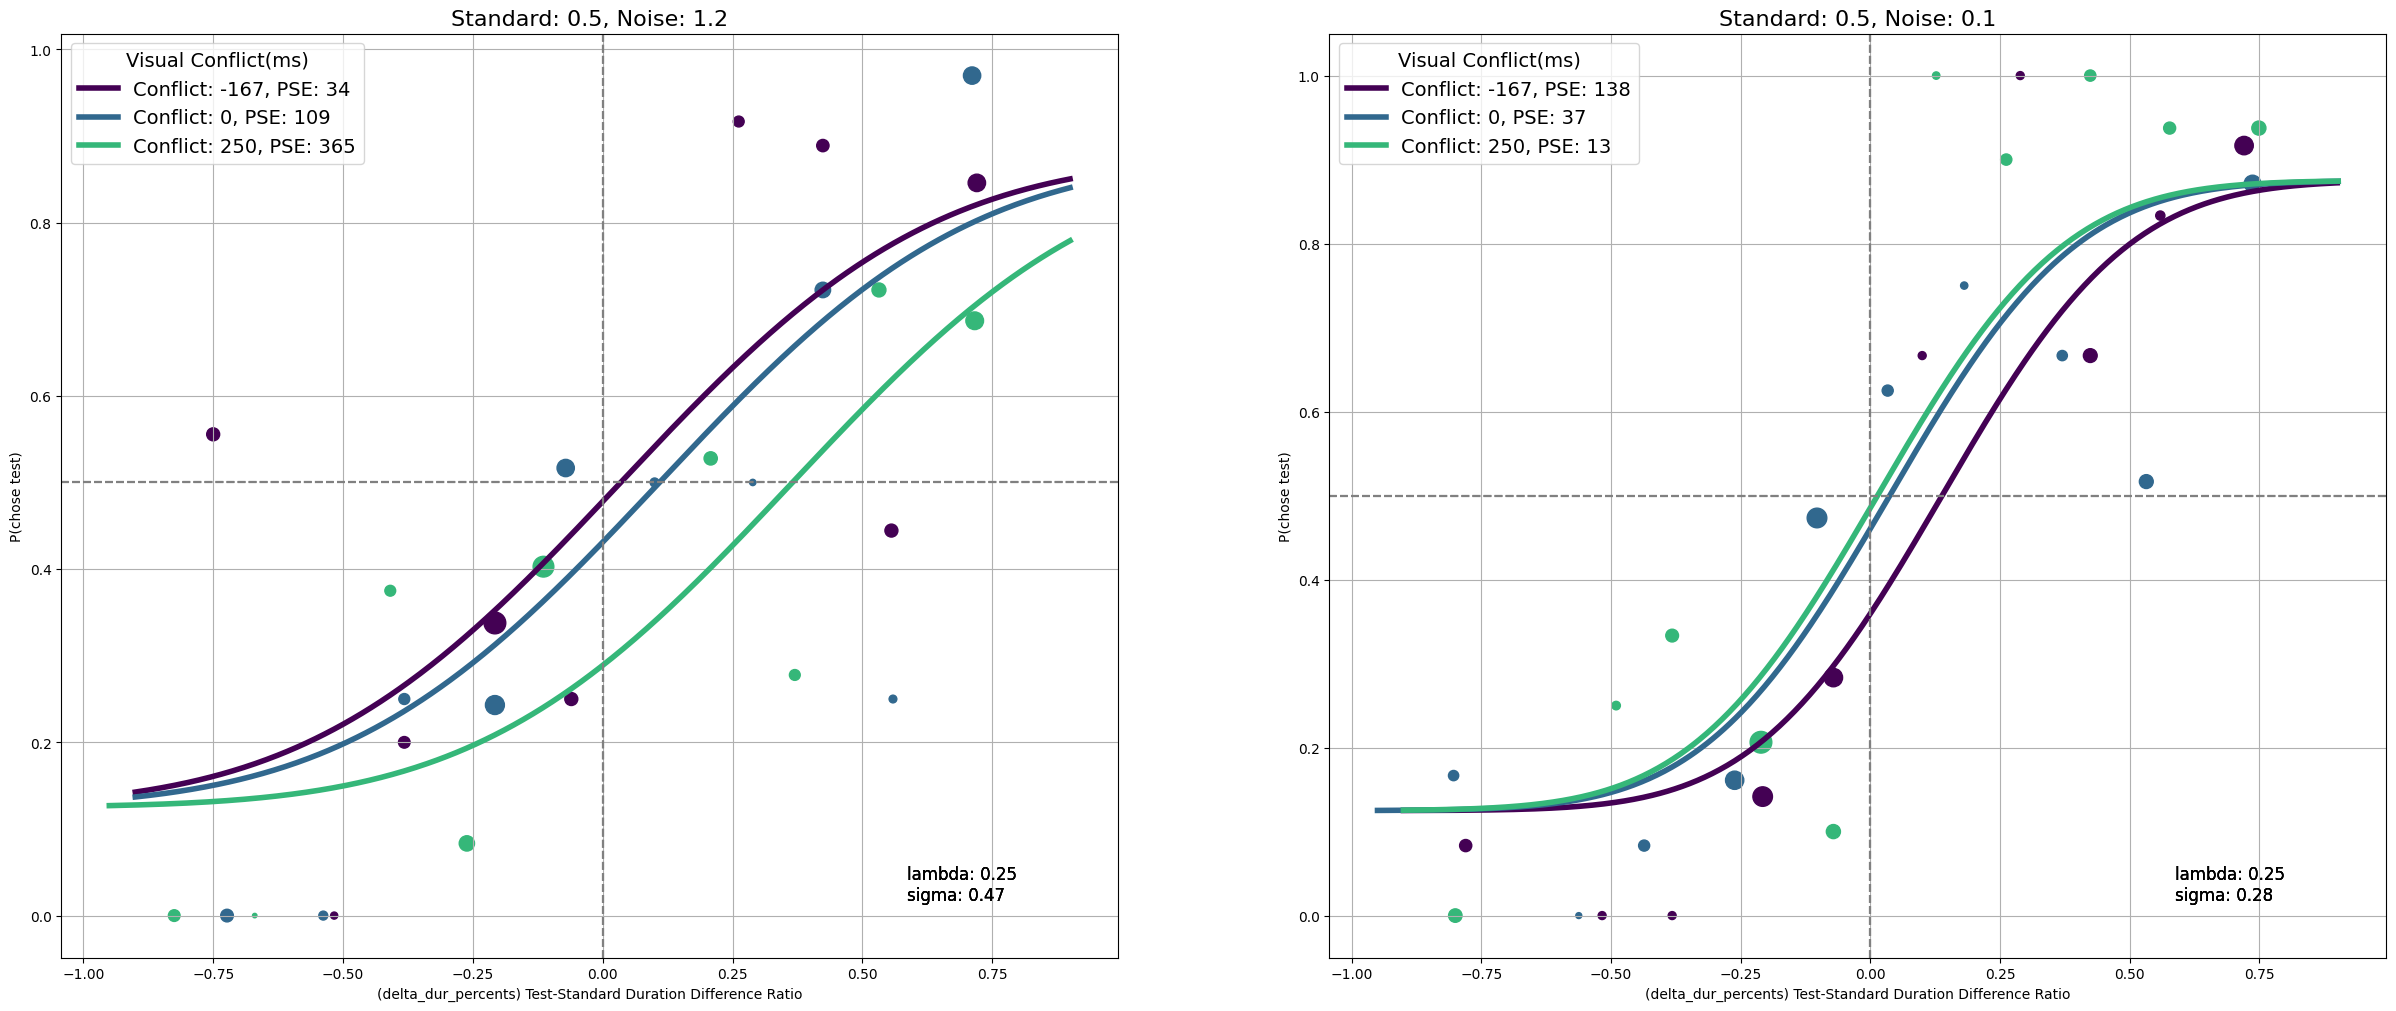

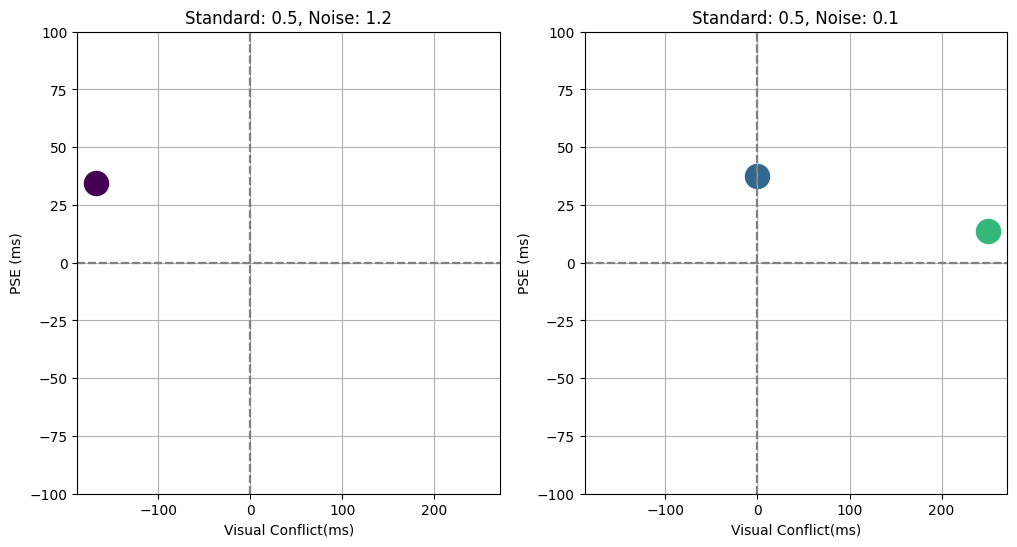

In [67]:
plt.figure(figsize=(12*2.5, 6*2))
m=0
for i, standardLevel in enumerate(uniqueStandard):

    print(f"fitted lambda: {lambda_}")
    for j, audioNoiseLevel in enumerate(uniqueSensory):
        for k, conflictLevel in enumerate(uniqueConflict):
            lambda_, mu, sigma = get_params(best_fit.x, conflictLevel, audioNoiseLevel, nLambda, nSigma)
            m+=1        
            
            # Filter the data for the current standard and audio noise levels
            df=data[data[standardVar]==standardLevel]
            df=df[df[sensoryVar]==audioNoiseLevel]
            df=df[df[conflictVar]==conflictLevel]
            dfFiltered=groupByChooseTest(df)
            levels = dfFiltered[intensityVariable].values
            responses = dfFiltered['num_of_chose_test'].values
            totalResponses = dfFiltered['total_responses'].values
            
            # Fit the psychometric function
            plt.subplot(1, 2, j+1)
            maxX= max(levels)+0.1
            minX= min(levels)-0.1
            #plt.ylim(0, 1)
            
            #plt.xlim(-1, maxX)
            x=np.linspace(minX, maxX, 500)
            y = psychometric_function(x, lambda_, mu, sigma)
            color=sns.color_palette("viridis", as_cmap=True)(k / len(uniqueConflict))  # Use a colormap for different conflict levels
            plt.plot(x, y, color=color, label=f"Conflict: {int(conflictLevel*1000)}, PSE: {int(mu*1000)}", linewidth=4)
            
            #plt.scatter(levels, responses/totalResponses, color=color) # plot real data
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel(f"({intensityVariable}) Test-Standard Duration Difference Ratio")
            plt.ylabel("P(chose test)")
            plt.title(f"Standard: {standardLevel}, Noise: {audioNoiseLevel}", fontsize=16)
            plt.legend(title="Visual Conflict(ms)", fontsize=14, title_fontsize=14)
            plt.grid()
            bin_and_plot(dfFiltered, bin_method='cut', bins=10, plot=True,color=color)
            plt.text( 0.8, 0.1, f"lambda: {lambda_:.2f}\nsigma: {sigma:.2f}", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)


            


# New plot showing the relation between the conflict and pse so that conflict should be on x axis and pse(mu based on conflict level) on y axis
plt.figure(figsize=(12, 6))
m=0
for i, standardLevel in enumerate(uniqueStandard):
    print(f"fitted lambda: {lambda_}")
    for j, audioNoiseLevel in enumerate(uniqueSensory):
        for k, conflictLevel in enumerate(uniqueConflict):
            lambda_, mu, sigma = get_params(best_fit.x, conflictLevel, audioNoiseLevel, nLambda, nSigma)
            m+=1        
            plt.subplot(1, 2, j+1)
            color=sns.color_palette("viridis", as_cmap=True)(k / len(uniqueConflict))  # Use a colormap for different conflict levels
            plt.scatter(conflictLevel*1000, mu*1000, color=color, s=300) # plot real data
            plt.xlabel(f"Visual Conflict(ms)")
            plt.ylabel("PSE (ms)")
            plt.title(f"Standard: {standardLevel}, Noise: {audioNoiseLevel}")
            plt.grid()
            plt.axhline(y=0, color='gray', linestyle='--')
            plt.axvline(x=0, color='gray', linestyle='--')
            plt.ylim(-100, 100)
 

# Fit the psychometric function to the grouped data
#result = fit_psychometric_function(grouped, intensityVariable)



# Model for causal inference

In [23]:
# Create dataframe of empirical PSEs from your fitted model
pse_data = []

for noise in uniqueSensory:
    for conflict in uniqueConflict:
        _, mu, _ = get_params(best_fit.x, conflict, noise, nLambda, nSigma)
        pse_data.append({
            'audNoise': noise,
            'conflictDur': conflict,
            'empirical_PSE': mu
        })

pse_df = pd.DataFrame(pse_data)


In [24]:
def predict_pse_bci(mu_A, mu_V, p_common, w_A=0.6):
    """
    mu_A: actual auditory delta (typically 0)
    mu_V: visual conflict
    p_common: belief in common cause [0-1]
    w_A: weight assigned to auditory in integrated case
    """
    mu_integrated = w_A * mu_A + (1 - w_A) * mu_V
    return p_common * mu_integrated + (1 - p_common) * mu_A


In [25]:
from scipy.optimize import minimize

def fit_pc_per_noise(pse_df, w_A=0.6):
    pc_fits = {}
    for noise in pse_df['audNoise'].unique():
        subset = pse_df[pse_df['audNoise'] == noise]

        def mse_loss(p_c):
            preds = predict_pse_bci(
                mu_A=0,
                mu_V=subset['conflictDur'].values,
                p_common=p_c[0],
                w_A=w_A
            )
            return np.mean((preds - subset['empirical_PSE'].values)**2)

        result = minimize(mse_loss, x0=[0.5], bounds=[(0, 1)])
        pc_fits[noise] = result.x[0]
    
    return pc_fits


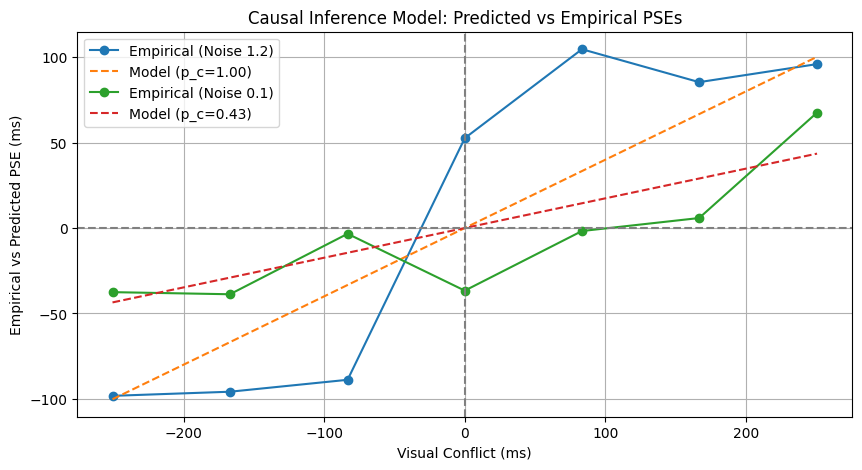

In [53]:
pc_by_noise = fit_pc_per_noise(pse_df, w_A=0.6)

plt.figure(figsize=(10, 5))
for noise in uniqueSensory:
    subset = pse_df[pse_df['audNoise'] == noise]
    p_c = pc_by_noise[noise]
    predicted = predict_pse_bci(mu_A=0, mu_V=subset['conflictDur'].values, p_common=p_c, w_A=0.6)

    plt.plot(subset['conflictDur']*1000, subset['empirical_PSE']*1000, 'o-', label=f'Empirical (Noise {noise})')
    plt.plot(subset['conflictDur']*1000, predicted*1000, '--', label=f'Model (p_c={p_c:.2f})')

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Visual Conflict (ms)")
plt.ylabel("Empirical vs Predicted PSE (ms)")
plt.legend()
plt.title("Causal Inference Model: Predicted vs Empirical PSEs")
plt.grid()
plt.show()


In [66]:
# Define your known sigmas
sigma_v = 0.5
sigma_a_by_noise = {0.1: 0.22, 1.2: 0.8}

def compute_weights(sigma_a, sigma_v):
    w_a = 1 / sigma_a**2
    w_v = 1 / sigma_v**2
    w_A = w_a / (w_a + w_v)
    w_V = 1 - w_A
    return w_A, w_V

def predict_pse_bci_weighted(conflict, sigma_a, sigma_v, p_c):
    """
    Predict PSE using precision-based weights and causal inference blending.
    Assumes mu_A = 0 and mu_V = conflict.
    """
    _, w_V = compute_weights(sigma_a, sigma_v)
    return p_c * w_V * conflict

def fit_pc_per_noise_weighted(pse_df, sigma_v, sigma_a_by_noise):
    pc_fits = {}
    for noise in pse_df['audNoise'].unique():
        sigma_a = sigma_a_by_noise[noise]
        subset = pse_df[pse_df['audNoise'] == noise]

        def mse_loss(p_c):
            preds = [predict_pse_bci_weighted(row['conflictDur'], sigma_a, sigma_v, p_c[0])
                     for _, row in subset.iterrows()]
            return np.mean((subset['empirical_PSE'].values - preds)**2)

        result = minimize(mse_loss, x0=[0.5], bounds=[(0, 1)])
        pc_fits[noise] = result.x[0]
    
    return pc_fits


P common (weighted): {1.2: 0.6772191628566079, 0.1: 1.0}


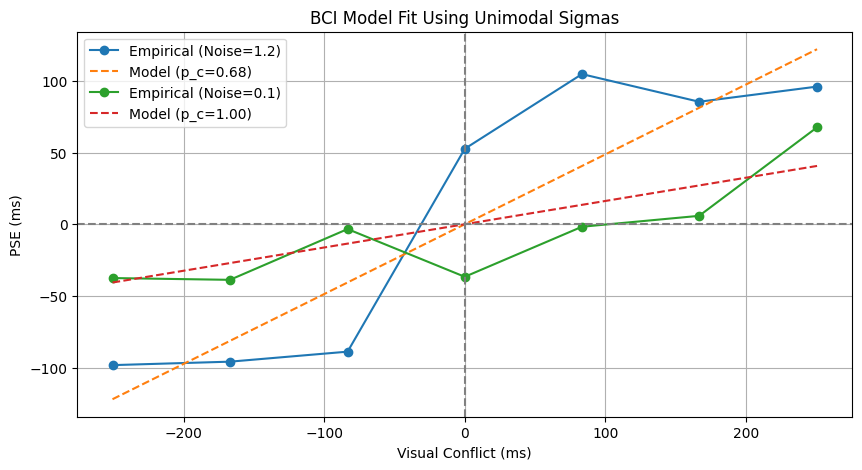

In [67]:
pc_weighted = fit_pc_per_noise_weighted(pse_df, sigma_v=0.5, sigma_a_by_noise=sigma_a_by_noise)
print(f"P common (weighted): {pc_weighted}")
plt.figure(figsize=(10, 5))
for noise in uniqueSensory:
    subset = pse_df[pse_df['audNoise'] == noise]
    p_c = pc_weighted[noise]
    sigma_a = sigma_a_by_noise[noise]
    predicted = [predict_pse_bci_weighted(row['conflictDur'], sigma_a, sigma_v, p_c) for _, row in subset.iterrows()]

    plt.plot(subset['conflictDur']*1000, subset['empirical_PSE']*1000, 'o-', label=f"Empirical (Noise={noise})")
    plt.plot(subset['conflictDur']*1000, np.array(predicted)*1000, '--', label=f"Model (p_c={p_c:.2f})")

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Visual Conflict (ms)")
plt.ylabel("PSE (ms)")
plt.title("BCI Model Fit Using Unimodal Sigmas")
plt.legend()
plt.grid()
plt.show()


# PLotting

In [ ]:
conflictLeves=sorted(data[conflictVar].unique())
standardDurLevels=sorted(data[standardVar].unique())
noiseLevels=sorted(data[sensoryVar].unique())
print(f"Standard duration levels: {standardDurLevels}, Conflict levels: {conflictLeves}, Noise levels: {noiseLevels}")

Standard duration levels: [0.49837], Conflict levels: [-0.24919, -0.08306, 0.08306, 0.16612], Noise levels: [0.1, 1.2]


In [ ]:
fig_w = 8
fig_h = 5

fitted lambda 0.03699418319056187 
At noise level 0.1 fitted sigma 0.29405360500357197 
Noise: 0.1, Conflict: -0.24919, fit sigma: 0.29405360500357197 fit mu: 0.07411435434692644


ValueError: Cannot cut empty array

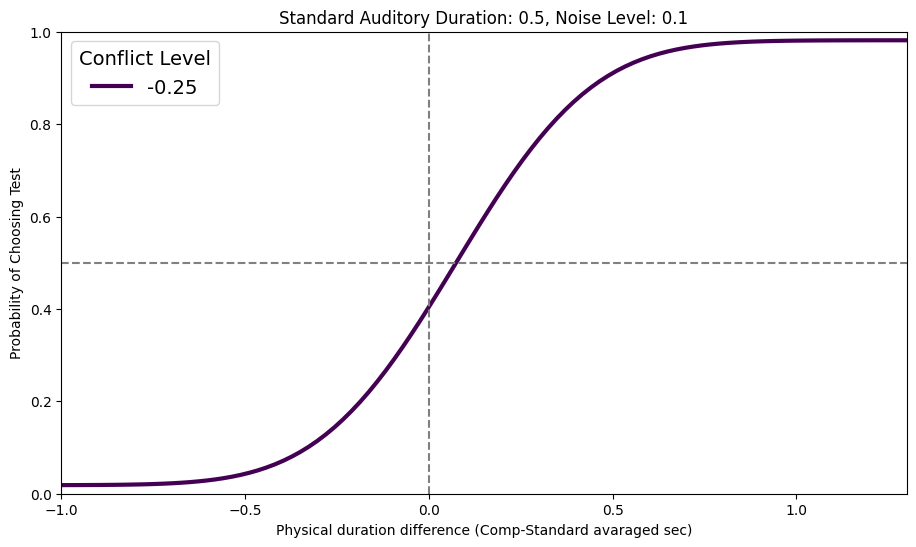

In [ ]:
plt.figure(figsize=(8*3,3*2))
#plt.Subplot(3,2)

m=0
for i, standardLevel in enumerate(standardDurLevels):
    lambda_ = best_fit.x[0]
    print(f"fitted lambda {lambda_} ")
    for j, noiseLevel in enumerate(noiseLevels):
        sigma=best_fit.x[j+1]
        print(f"At noise level {noiseLevel } fitted sigma {sigma} ")
        for k, conflictLevel in enumerate(conflictLeves):
            m+=1        
            
            mu=best_fit.x[m+2]
            #filter data
            df=data[data['conflictDur']==conflictLevel]
            df= df[df["standardDur"]==standardLevel]
            df=df[df["riseDur"]==noiseLevel]
            dfFiltered=groupByChooseTest(df)
            # select levels
            levels=dfFiltered[intensityVariable].values
            responses=dfFiltered['num_of_chose_test'].values
            totalResponses=dfFiltered['total_responses'].values
            # print fitted parameters

            print(f"Noise: {noiseLevel}, Conflict: {conflictLevel}, fit sigma: {sigma} fit mu: {mu}")
            # plot psychometric function
            plt.subplot(1,2,j+1)
            maxX = max(levels) if len(levels) > 0 else 1.3  # Handle case with no levels
            if maxX < 1.3:
                maxX = 1.3
            plt.xlim(-1, maxX)
            plt.ylim(0, 1)
            x = np.linspace(-1, maxX, 100)

            y = psychometric_function(x, lambda_,mu,sigma)  # Use muA0_fit for the mean

            color=sns.color_palette("viridis", as_cmap=True)(k / len(conflictLeves))  # Use a colormap for different conflict levels
            plt.plot(x, y, label=round(conflictLevel, 2), color=color, linewidth=3)  # Plot the fitted psychometric function
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel('Physical duration difference (Comp-Standard avaraged sec)')
            plt.ylabel('Probability of Choosing Test')
            plt.title(f'Standard Auditory Duration: {round(standardLevel,2)}, Noise Level: {round(noiseLevel,2)}')
            # add fitted parameters to the plot
            # plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {fitted_params[1]:.2f}\nsigma: {fitted_params[2]:.2f}', fontsize=12, 
            #          bbox=dict(facecolor='white', alpha=0.5))
            plt.legend(title="Conflict Level", fontsize=14, title_fontsize=14)
            bin_and_plot(dfFiltered, bin_method='cut', bins=8, plot=True,color=color)
            
